In [1]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Task a

In [3]:
df_sales = pd.read_csv("data/task4/Alcohol_Sales.csv")
df_sales.head()

,DATE,S4248SM144NCEN
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221


In [4]:
df_sales.shape

(325, 2)

In [5]:
df_sales.columns = ["DATE", "SALES"]

In [6]:
df_sales["DATE"] = pd.to_datetime(df_sales["DATE"])
df_sales.sort_values(by="DATE", inplace=True)
df_sales.head()
# already sotred

,DATE,SALES
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221


In [8]:
df_sales.dtypes

DATE     datetime64[ns]
SALES             int64
dtype: object

In [9]:
df_sales.set_index("DATE", inplace = True)

In [10]:
train_data, test_data = train_test_split(df_sales, test_size=0.3, shuffle=False)

In [11]:
scaler = StandardScaler()
train_data["SALES"] = scaler.fit_transform(train_data[["SALES"]])
test_data["SALES"] = scaler.transform(test_data[["SALES"]])


In [12]:
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i + sequence_length]
        target = data.iloc[i + sequence_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

X_train, y_train = create_sequences(train_data, 5)
X_test, y_test = create_sequences(test_data, 5)


In [16]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(64, activation="relu", input_shape=(5, 1)))
model.add(Dense(1))  # forecasting


In [19]:
from tensorflow.keras.metrics import RootMeanSquaredError
model.compile(optimizer="adam", loss="mean_squared_error", metrics=[RootMeanSquaredError()])

In [20]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose = 0, validation_split= 0.2)

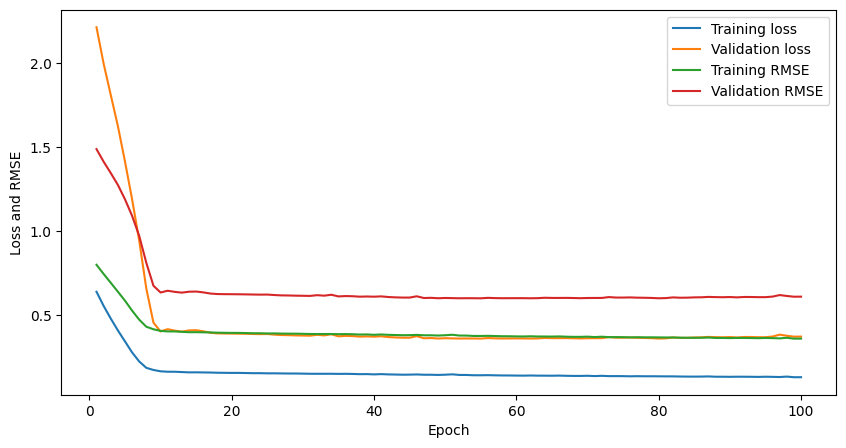

In [21]:
import matplotlib.pyplot as plt

training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
training_RMSE = history.history["root_mean_squared_error"]
validation_RMSE = history.history["val_root_mean_squared_error"]

epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label="Training loss")
plt.plot(epochs, validation_loss, label="Validation loss")
plt.plot(epochs, training_RMSE, label="Training RMSE")
plt.plot(epochs, validation_RMSE, label="Validation RMSE")
plt.xlabel("Epoch")
plt.ylabel("Loss and RMSE")
plt.legend()
plt.show()

In [22]:
train_predictions = model.predict(X_test).flatten()
train_results = pd.DataFrame({"Train Predictions": train_predictions, "Actuals": y_test.flatten()})
train_results.head()

3/3 [==============================] - 0s 2ms/step


,Train Predictions,Actuals
0,2.656151,1.853548
1,0.951925,2.572506
2,1.238490,1.404003
3,1.345701,2.115652
4,1.747087,1.915158


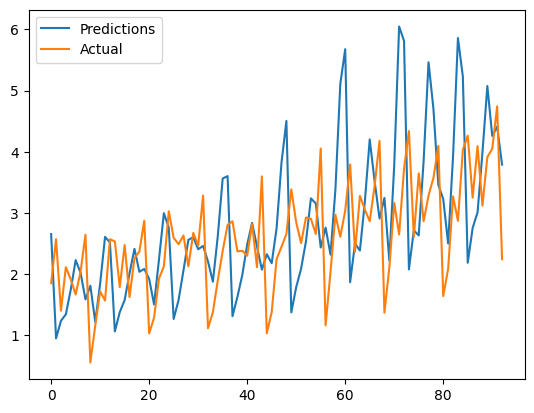

In [23]:
import matplotlib.pyplot as plt
plt.plot(train_results["Train Predictions"][:100], label = "Predictions")
plt.plot(train_results["Actuals"][:100], label = "Actual")
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")


3/3 [==============================] - 0s 2ms/step
Root Mean Squared Error (RMSE): 1.1580535011121837


In [26]:
print(f"Training Accuracy: {history.history['root_mean_squared_error'][-1]}")

Training Accuracy: 0.3588145673274994


In [27]:
from my_utils import get_hyperparameters
get_hyperparameters(model)

Learning Rate: 0.0010
Number of Hidden Layers: 0
Number of Neurons in Each Hidden Layer: []
Activation Functions: ['linear']
Loss Function: mean_squared_error
Optimizer: Adam
Metrics for Evaluation: ['loss', 'root_mean_squared_error']


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import mean_squared_error
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [76]:
window_size = []
RMSE = []
for seq_length in range(2,49):
    #split
    train_data, test_data = train_test_split(df_sales, test_size=0.2, shuffle=False)
    # scaling
    scaler = StandardScaler()
    train_data["SALES"] = scaler.fit_transform(train_data[["SALES"]])
    test_data["SALES"] = scaler.transform(test_data[["SALES"]])
    # make tensor sequence
    sequence_length = seq_length
    X_train, y_train = create_sequences(train_data, sequence_length)
    X_test, y_test = create_sequences(test_data, sequence_length)
    #model
    model = Sequential()
    model.add(LSTM(64, activation="relu", input_shape=(sequence_length, 1)))
    model.add(Dense(1))  # Output layer for forecasting
    #compile
    model.compile(optimizer="adam", loss="mean_squared_error")
    #train
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose = 0)
    #predict
    y_pred = model.predict(X_test)
    # Calculate RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # add to df
    window_size.append(seq_length)
    RMSE.append(rmse)

data = {"seq_length": window_size, "RMSE": RMSE}
df = pd.DataFrame(data)
df = df.sort_values(by="RMSE")
df

1/1 [==============================] - 0s 129ms/step


,seq_length,RMSE
32,34,0.567180
6,8,0.608150
7,9,0.614103
19,21,0.655862
33,35,0.712045
3,5,0.724657
38,40,0.726131
9,11,0.731320
13,15,0.751530
2,4,0.767610


# task b

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [65]:
df_miles = pd.read_csv("data/task4/Miles_Traveled.csv")

In [66]:
df_miles.head(3)

,DATE,TRFVOLUSM227NFWA
0,1970-01-01,80173.0
1,1970-02-01,77442.0
2,1970-03-01,90223.0


In [67]:
df_miles.columns = ["DATE", "MILES"]

In [68]:
df_miles["DATE"] = pd.to_datetime(df_miles["DATE"])
df_miles.sort_values(by="DATE", inplace=True)

In [69]:
df_miles.set_index("DATE", inplace=True)

In [70]:
df_miles

,MILES
DATE,
1970-01-01,80173.0
1970-02-01,77442.0
1970-03-01,90223.0
1970-04-01,89956.0
1970-05-01,97972.0
...,...
2018-08-01,286608.0
2018-09-01,260595.0
2018-10-01,282174.0


<Axes: xlabel='DATE'>

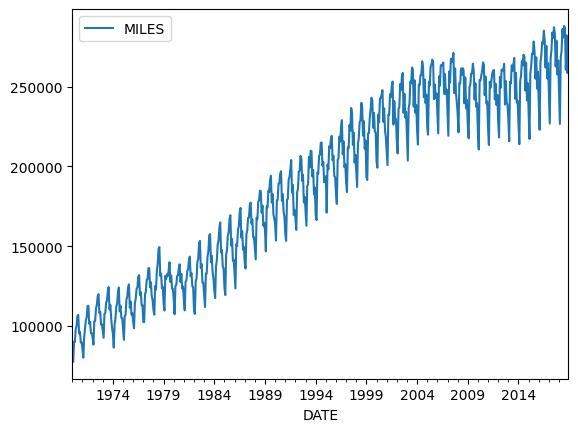

In [71]:
df_miles.plot()

In [72]:
train_data, test_data = train_test_split(df_miles, test_size=0.3, shuffle=False)

In [73]:
scaler = StandardScaler()
train_data["MILES"] = scaler.fit_transform(train_data[["MILES"]])

In [74]:
test_data["MILES"] = scaler.fit_transform(test_data[["MILES"]])

In [75]:
# train_data, test_data = train_test_split(df_miles, test_size=0.3, shuffle=False)
# def create_sequences(data, sequence_length):
#     sequences = []
#     targets = []
#     for i in range(len(data) - sequence_length):
#         seq = data.iloc[i:i + sequence_length]
#         target = data.iloc[i + sequence_length]
#         sequences.append(seq)
#         targets.append(target)
#     return np.array(sequences), np.array(targets)

# sequence_length = 10
# X_train, y_train = create_sequences(train_data, sequence_length)
# X_test, y_test = create_sequences(test_data, sequence_length)
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

# model = Sequential()
# model.add(LSTM(64, activation="relu", input_shape=(sequence_length, 1)))
# model.add(Dense(1))  # Output layer for forecasting

# model.compile(optimizer="adam", loss="mean_squared_error")
# model.fit(X_train, y_train, epochs=100, batch_size=32)

# 
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        # to make a list of list
        row = [[a] for a in df_as_np[i:i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size]
        y.append(label)

    return np.array(X), np.array(y)

In [76]:
X_train, y_train = df_to_X_y(train_data, 24)
X_test, y_test = df_to_X_y(test_data, 24)

In [77]:
model = Sequential()
model.add(InputLayer((24,1)))
model.add(LSTM(64))
model.add(Dense(8, "relu"))
model.add(Dense(1, "linear"))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dense_5 (Dense)             (None, 8)                 520       
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [78]:
model.compile(loss = MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [97]:
history = model.fit(X_train, y_train, validation_split = 0.2, epochs = 50, verbose = 0)

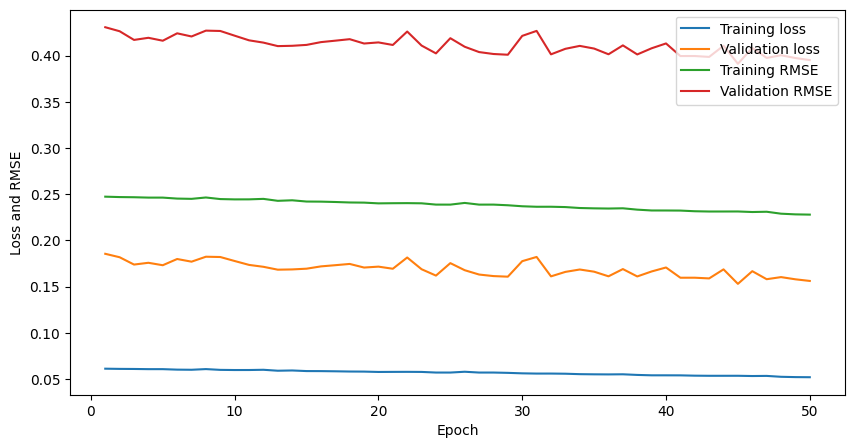

In [98]:
import matplotlib.pyplot as plt

training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
training_RMSE = history.history["root_mean_squared_error"]
validation_RMSE = history.history["val_root_mean_squared_error"]

epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label="Training loss")
plt.plot(epochs, validation_loss, label="Validation loss")
plt.plot(epochs, training_RMSE, label="Training RMSE")
plt.plot(epochs, validation_RMSE, label="Validation RMSE")
plt.xlabel("Epoch")
plt.ylabel("Loss and RMSE")
plt.legend()
plt.show()

In [99]:
from my_utils import get_hyperparameters
get_hyperparameters(model)

Learning Rate: 0.0001
Number of Hidden Layers: 1
Number of Neurons in Each Hidden Layer: [1]
Activation Functions: ['relu', 'linear']
Loss Function: <keras.src.losses.MeanSquaredError object at 0x7f194a58dff0>
Optimizer: Adam
Metrics for Evaluation: ['loss', 'root_mean_squared_error']


In [100]:
print(f"Training RMSE : {history.history['root_mean_squared_error'][-1]}")

Training RMSE : 0.227908194065094


In [101]:
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

5/5 [==============================] - 0s 3ms/step
Root Mean Squared Error (RMSE): 0.851748634335229


In [102]:
predictions = model.predict(X_test).flatten()
train_results = pd.DataFrame({"Predictions": predictions, "Actuals": y_test.flatten()})
train_results

5/5 [==============================] - 0s 3ms/step


,Predictions,Actuals
0,-0.027137,-0.161790
1,0.011805,0.590592
2,0.014652,0.614950
3,0.022752,0.593607
4,0.008324,0.699139
...,...,...
148,0.980307,1.964461
149,0.945732,0.426529
150,0.864604,1.702315
151,0.901810,0.307990


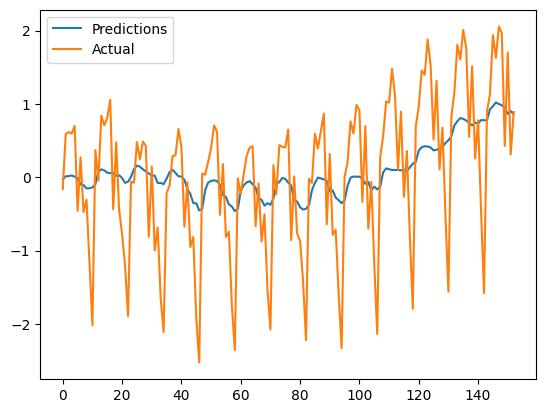

In [103]:
plt.plot(train_results["Predictions"], label = "Predictions")
plt.plot(train_results["Actuals"], label = "Actual")
plt.legend()
plt.show()

In [ ]:
# just to test
# window_size = []
# RMSE = []
# for seq_length in range(2,49):
#     # make tensor sequence
#     X, y = df_to_X_y(df_miles, seq_length)
#     # split
#     split_index = int(len(df_miles) * 0.7)
#     X_train = X[:split_index]
#     y_train = y[:split_index]
#     X_test = X[split_index:]
#     y_test = y[split_index:]
#     #model
#     model = Sequential()
#     model.add(InputLayer((seq_length,1)))
#     model.add(LSTM(64))
#     # model.add(Dense(8, "relu"))
#     model.add(Dense(1, "linear"))
#     #compile
#     model.compile(loss = MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
#     # get validation set
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)
#     #train
#     history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 50, verbose = 0)
#     #predict
#     y_pred = model.predict(X_test)
#     # Calculate RMSE (Root Mean Squared Error)
#     rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#     # add to df
#     window_size.append(seq_length)
#     RMSE.append(rmse)

# data = {"seq_length": window_size, "RMSE": RMSE}
# df = pd.DataFrame(data)

In [104]:
# df = df.sort_values(by="RMSE")
# df

,seq_length,RMSE
40,42,0.361969
43,45,0.382726
38,40,0.397693
41,43,0.402696
42,44,0.412484
25,27,0.419008
45,47,0.425404
39,41,0.438233
44,46,0.439144
28,30,0.443626
